In [1]:
!pip install torch==1.13.1 torchtext torchinfo datasets matplotlib

In [2]:
import torch, model, importlib
importlib.reload(model);

In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


# Data loading and preparation

In [4]:
import datasets

dataset = datasets.load_dataset('daily_dialog')
dataset

Found cached dataset daily_dialog (/home/onyxia/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 11118
    })
    validation: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
})

In [5]:
from torchtext.vocab import GloVe, vocab

pretrained_vectors = GloVe(name="6B", dim=50)
pretrained_vocab = vocab(pretrained_vectors.stoi)
pretrained_vocab.insert_token("<unk>", 0)
pretrained_vocab.insert_token("<pad>", 1)
pretrained_vocab.set_default_index(0)
pretrained_embeddings = pretrained_vectors.vectors.to(device)
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
vocab_stoi = pretrained_vocab.get_stoi()

In [6]:
import numpy as np
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

max_len = max([
    len(tokenizer(sentence))
     for dialog in dataset['train']['dialog'] + dataset['validation']['dialog'] + dataset['test']['dialog']
     for sentence in dialog 
])
max_len

290

In [7]:
@np.vectorize
def numericalize(word, vocab_stoi):
    return vocab_stoi[word] if word in vocab_stoi else 0

def preprocess(sentence, max_len):
    # Tokenizer, word to indices, padding
    sentence = tokenizer(sentence.lower())
    sentence = sentence + ["<pad>" for _ in range(max_len-len(sentence))]
    sentence = numericalize(sentence, vocab_stoi)
    return sentence
    

In [8]:
# For each dialog, we take the first 5 utterances
new_dataset = dict()
for split in ['train', 'validation', 'test']:
    new_dataset[split] = [
        (
            np.array([preprocess(sentence, max_len=max_len) for sentence in dialog[:5]]),
            np.array([a for a in act[:5]])
        )
        for dialog, act in zip(dataset[split]['dialog'], dataset[split]['act'])
        if len(dialog) >= 5
    ]

In [9]:
class DialogActDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return dict(
            dialog = torch.tensor(self.data[idx][0]),
            act = torch.tensor(self.data[idx][1])
        )

In [10]:
kwargs = dict(
    batch_size = 128,
    shuffle = True,
    drop_last = True,
    generator = torch.Generator(device=device)
)

train_loader = torch.utils.data.DataLoader(
    DialogActDataset(new_dataset['train']), **kwargs
)
val_loader = torch.utils.data.DataLoader(
    DialogActDataset(new_dataset['validation']), **kwargs
)
test_loader = torch.utils.data.DataLoader(
    DialogActDataset(new_dataset['test']), **kwargs
)

In [11]:
def evaluate(model, test_loader, device):
    """Measures the accuracy of `model` on `test_loader`."""
    model.eval()
    with torch.no_grad():
        correct = 0
        for batch_idx, batch in enumerate(test_loader):
            x = batch['dialog'].to(device)
            target = batch['act'].to(device)
            out = model(x)
            out_argmax = torch.argmax(out, dim=-1)
            correct += torch.sum( torch.where( out_argmax == target, 1, 0 ) ).item()
            
    return correct / len(test_loader) / kwargs['batch_size'] / 5

In [12]:
def evaluate(model, test_loader, device):
    """Measures the accuracy of `model` on `test_loader`."""
    model.eval()
    with torch.no_grad():
        correct = 0
        for batch_idx, batch in enumerate(test_loader):
            x = batch['dialog'].to(device)
            target = batch['act'].to(device)
            out = model(x)
            out_argmax = torch.argmax(out, dim=-1)
            correct += torch.sum( torch.where( out_argmax == target, 1, 0 ) ).item()
            
    return correct / len(test_loader) / kwargs['batch_size'] / 5

# Vanilla Attention
## Training

In [13]:
import torchinfo

network = model.Seq2SeqModel(
    pretrained_embeddings = pretrained_embeddings,
    encoder = model.HierarchicalEncoder(
        input_size = pretrained_embeddings.shape[1],
        sequence_length = 5,
        hidden_size = 128,
        persona_level = False,
    ),
    decoder = model.VanilladAttentionDecoder(
        hidden_size = 128,
        sequence_length = 5,
    ),
    nb_classes = 5,
    hidden_size = 128,
)
torchinfo.summary(network)

Layer (type:depth-idx)                   Param #
Seq2SeqModel                             --
├─Embedding: 1-1                         (20,000,050)
├─HierarchicalEncoder: 1-2               --
│    └─GRU: 2-1                          138,240
│    └─GRU: 2-2                          296,448
├─VanilladAttentionDecoder: 1-3          --
│    └─Linear: 2-3                       513
│    └─GRUCell: 2-4                      394,752
├─Linear: 1-4                            1,285
Total params: 20,831,288
Trainable params: 831,238
Non-trainable params: 20,000,050

In [14]:
def train(model, train_loader, val_loader, optimizer, loss_fn, device, n_epochs=10):
    train_losses, val_losses, val_accuracies = [], [], []
    
    model.to(device)
    for epoch in range(n_epochs):
        # Training
        model.train()
        train_loss = 0

        for batch_idx, batch in enumerate(train_loader):

            optimizer.zero_grad()

            x = batch['dialog'].to(device)
            target = batch['act'].to(device)

            out = model(x).transpose(1,2)

            loss = loss_fn(out, target.long())
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            
        if (epoch+1)%20 == 0: print(f'Epoch {epoch+1}/{n_epochs}, training loss: {train_loss/len(train_loader)/kwargs["batch_size"]:.4g}')
        train_losses.append(train_loss/len(train_loader)/kwargs['batch_size'])

                
        # Testing
        model.eval()
        with torch.no_grad():
            loss = 0
            for batch_idx, batch in enumerate(val_loader):
                x = batch['dialog'].to(device)
                target = batch['act'].to(device)
                out = model(x).transpose(1,2)
                loss += loss_fn(out, target.long()).item()
                
        if (epoch+1)%20 == 0: print(f'Epoch {epoch+1}/{n_epochs}, val loss: {loss/len(val_loader)/kwargs["batch_size"]:.4g}')
        val_losses.append(loss/len(val_loader)/kwargs['batch_size'])

        acc = evaluate(network, val_loader, device)
        if (epoch+1)%20 == 0: print(f'Epoch {epoch+1}/{n_epochs}, val accuracy: {acc:.4g}')
        val_accuracies.append(acc)
    
    return train_losses, val_losses, val_accuracies

train_losses, val_losses, val_accuracies = train(
    network,
    train_loader,
    test_loader,
    optimizer = torch.optim.SGD(network.parameters(), lr=3e-3),
    loss_fn = torch.nn.CrossEntropyLoss(),
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    n_epochs = 300
)

Epoch 20/300, training loss: 0.01168
Epoch 20/300, val loss: 0.01168
Epoch 20/300, val accuracy: 0.4116
Epoch 40/300, training loss: 0.0114
Epoch 40/300, val loss: 0.01142
Epoch 40/300, val accuracy: 0.4097
Epoch 60/300, training loss: 0.01131
Epoch 60/300, val loss: 0.01132
Epoch 60/300, val accuracy: 0.4625
Epoch 80/300, training loss: 0.01127
Epoch 80/300, val loss: 0.01126
Epoch 80/300, val accuracy: 0.4597
Epoch 100/300, training loss: 0.01126
Epoch 100/300, val loss: 0.01126
Epoch 100/300, val accuracy: 0.4675
Epoch 120/300, training loss: 0.01124
Epoch 120/300, val loss: 0.01127
Epoch 120/300, val accuracy: 0.4647
Epoch 140/300, training loss: 0.01124
Epoch 140/300, val loss: 0.01126
Epoch 140/300, val accuracy: 0.4703
Epoch 160/300, training loss: 0.01124
Epoch 160/300, val loss: 0.01122
Epoch 160/300, val accuracy: 0.4628
Epoch 180/300, training loss: 0.01124
Epoch 180/300, val loss: 0.01121
Epoch 180/300, val accuracy: 0.4591
Epoch 200/300, training loss: 0.01123
Epoch 200/30

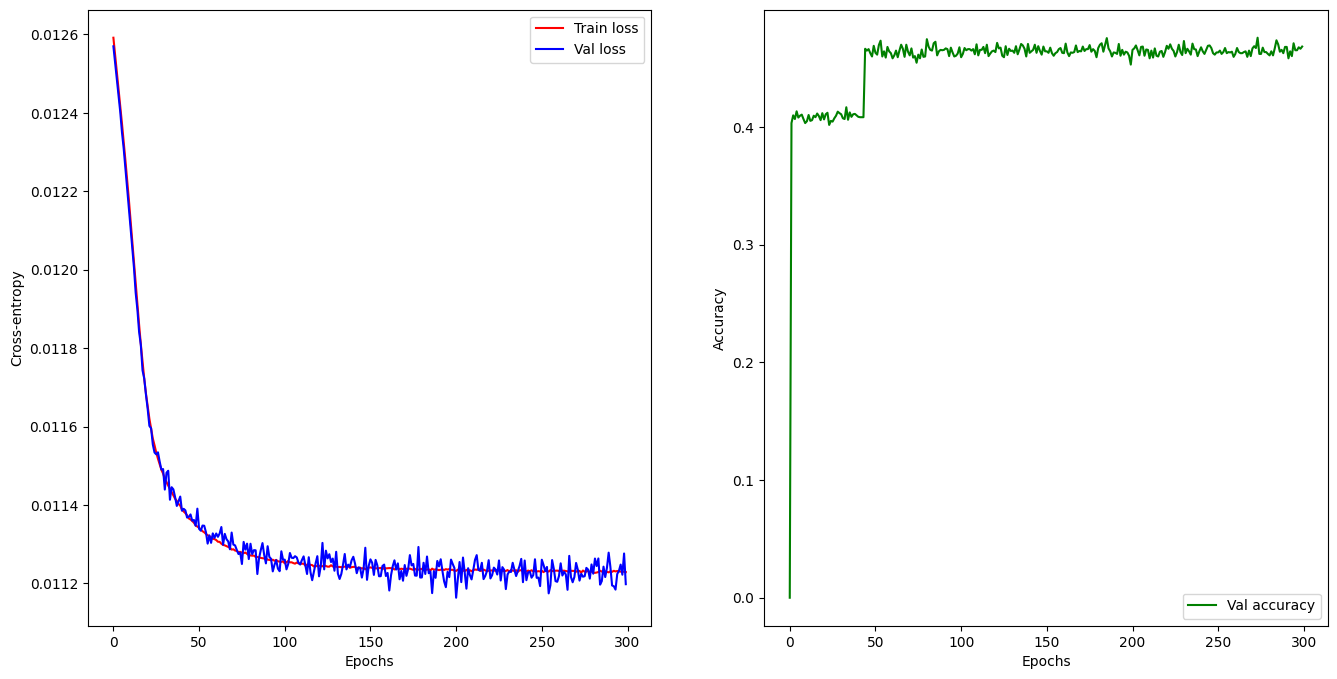

In [15]:
import matplotlib.pyplot as plt

def plot_progress(train_losses, val_losses, val_accuracies):
    fig, (left, right) = plt.subplots(1, 2, figsize=(16,8))

    left.plot(train_losses, color='red', label='Train loss')
    left.plot(val_losses, color='blue', label='Val loss')
    left.legend()
    left.set_xlabel('Epochs')
    left.set_ylabel('Cross-entropy')

    right.plot(val_accuracies, color='green', label='Val accuracy')
    right.legend()
    right.set_xlabel('Epochs')
    right.set_ylabel('Accuracy')
    fig.show()

plot_progress(train_losses, val_losses, val_accuracies)

In [16]:
torch.save(network, 'model_vanilla_attention.pkl')

## Evaluation with accuracy

In [17]:
network = torch.load('model_vanilla_attention.pkl') 
evaluate(network, test_loader, device)

0.4659375

# Hard-guided Attention

In [18]:
network = model.Seq2SeqModel(
    pretrained_embeddings = pretrained_embeddings,
    encoder = model.HierarchicalEncoder(
        input_size = pretrained_embeddings.shape[1],
        sequence_length = 5,
        hidden_size = 128,
        persona_level = False,
    ),
    decoder = model.HardGuidedAttentionDecoder(
        hidden_size = 128,
        sequence_length = 5,
    ),
    nb_classes = 5,
    hidden_size = 128,
)
torchinfo.summary(network)

Layer (type:depth-idx)                   Param #
Seq2SeqModel                             --
├─Embedding: 1-1                         (20,000,050)
├─HierarchicalEncoder: 1-2               --
│    └─GRU: 2-1                          138,240
│    └─GRU: 2-2                          296,448
├─HardGuidedAttentionDecoder: 1-3        --
│    └─GRUCell: 2-3                      394,752
├─Linear: 1-4                            1,285
Total params: 20,830,775
Trainable params: 830,725
Non-trainable params: 20,000,050

In [19]:
train_losses, test_losses, val_accuracies = train(
    network,
    train_loader,
    test_loader,  
    optimizer = torch.optim.SGD(network.parameters(), lr=3e-3),
    loss_fn = torch.nn.CrossEntropyLoss(),
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    n_epochs = 300
)

Epoch 20/300, training loss: 0.01165
Epoch 20/300, val loss: 0.01164
Epoch 20/300, val accuracy: 0.4116
Epoch 40/300, training loss: 0.01137
Epoch 40/300, val loss: 0.0114
Epoch 40/300, val accuracy: 0.4634
Epoch 60/300, training loss: 0.01129
Epoch 60/300, val loss: 0.01129
Epoch 60/300, val accuracy: 0.4591
Epoch 80/300, training loss: 0.01127
Epoch 80/300, val loss: 0.01126
Epoch 80/300, val accuracy: 0.4669
Epoch 100/300, training loss: 0.01125
Epoch 100/300, val loss: 0.01124
Epoch 100/300, val accuracy: 0.4641
Epoch 120/300, training loss: 0.01125
Epoch 120/300, val loss: 0.01125
Epoch 120/300, val accuracy: 0.4559
Epoch 140/300, training loss: 0.01124
Epoch 140/300, val loss: 0.01123
Epoch 140/300, val accuracy: 0.47
Epoch 160/300, training loss: 0.01124
Epoch 160/300, val loss: 0.01125
Epoch 160/300, val accuracy: 0.4619
Epoch 180/300, training loss: 0.01124
Epoch 180/300, val loss: 0.01122
Epoch 180/300, val accuracy: 0.4603
Epoch 200/300, training loss: 0.01124
Epoch 200/300,

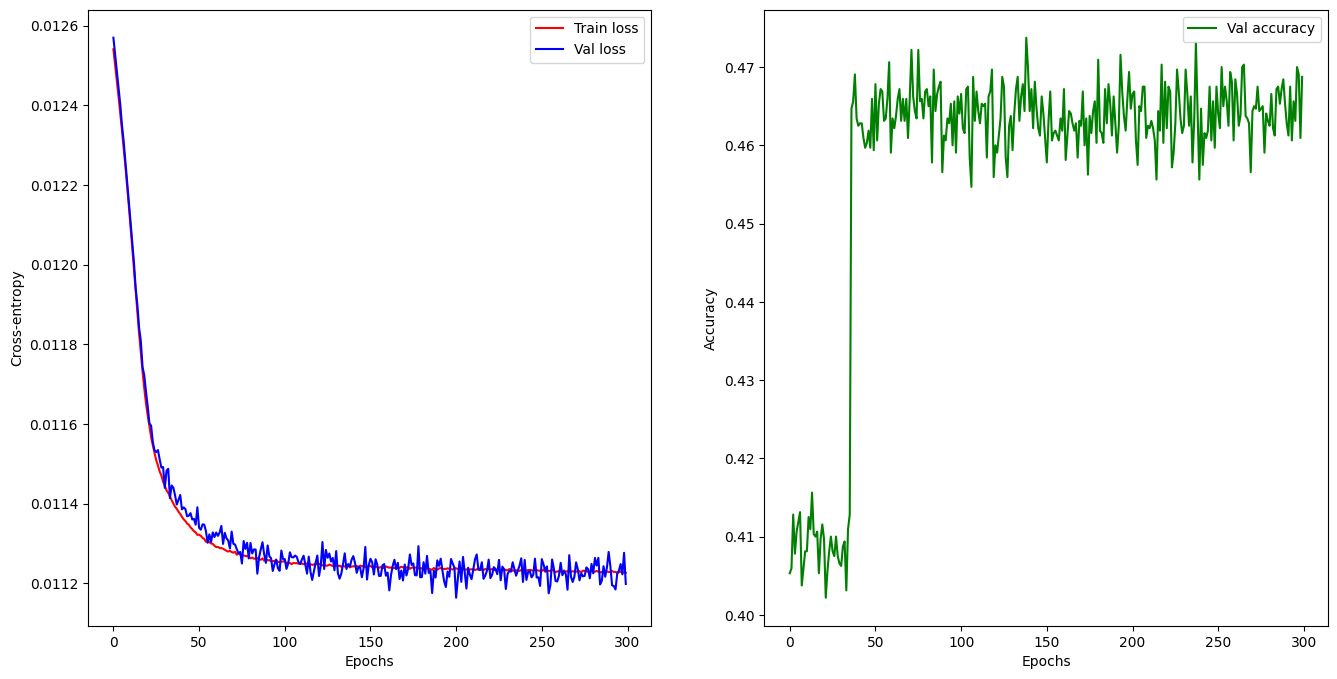

In [20]:
plot_progress(train_losses, val_losses, val_accuracies)

In [21]:
torch.save(network, 'model_hard_guided.pkl')

In [42]:
network = torch.load('model_hard_guided.pkl') 
evaluate(network, test_loader, device)

0.4703125

# Soft Guided Attention
## Training

In [22]:
network = model.Seq2SeqModel(
    pretrained_embeddings = pretrained_embeddings,
    encoder = model.HierarchicalEncoder(
        input_size = pretrained_embeddings.shape[1],
        sequence_length = 5,
        hidden_size = 128,
        persona_level = False,
    ),
    decoder = model.SoftGuidedAttentionDecoder(
        hidden_size = 128,
        sequence_length = 5,
    ),
    nb_classes = 5,
    hidden_size = 128,
)
torchinfo.summary(network)

Layer (type:depth-idx)                   Param #
Seq2SeqModel                             --
├─Embedding: 1-1                         (20,000,050)
├─HierarchicalEncoder: 1-2               --
│    └─GRU: 2-1                          138,240
│    └─GRU: 2-2                          296,448
├─SoftGuidedAttentionDecoder: 1-3        --
│    └─Linear: 2-3                       513
│    └─GRUCell: 2-4                      394,752
├─Linear: 1-4                            1,285
Total params: 20,831,288
Trainable params: 831,238
Non-trainable params: 20,000,050

In [ ]:
train_losses, test_losses, val_accuracies = train(
    network,
    train_loader,
    test_loader,  
    optimizer = torch.optim.SGD(network.parameters(), lr=3e-3),
    loss_fn = torch.nn.CrossEntropyLoss(),
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    n_epochs = 300
)

Epoch 20/300, training loss: 0.01168
Epoch 20/300, val loss: 0.01163
Epoch 20/300, val accuracy: 0.4078
Epoch 40/300, training loss: 0.01139
Epoch 40/300, val loss: 0.01141
Epoch 40/300, val accuracy: 0.4072
Epoch 60/300, training loss: 0.0113
Epoch 60/300, val loss: 0.01133
Epoch 60/300, val accuracy: 0.4653
Epoch 80/300, training loss: 0.01127
Epoch 80/300, val loss: 0.01123
Epoch 80/300, val accuracy: 0.4603
Epoch 100/300, training loss: 0.01125
Epoch 100/300, val loss: 0.01126
Epoch 100/300, val accuracy: 0.4653
Epoch 120/300, training loss: 0.01124
Epoch 120/300, val loss: 0.01125
Epoch 120/300, val accuracy: 0.4616
Epoch 140/300, training loss: 0.01124
Epoch 140/300, val loss: 0.01125
Epoch 140/300, val accuracy: 0.4606
Epoch 160/300, training loss: 0.01124
Epoch 160/300, val loss: 0.01119
Epoch 160/300, val accuracy: 0.46
Epoch 180/300, training loss: 0.01124
Epoch 180/300, val loss: 0.01124
Epoch 180/300, val accuracy: 0.4616
Epoch 200/300, training loss: 0.01123
Epoch 200/300,

In [ ]:
plot_progress(train_losses, val_losses, val_accuracies)

In [ ]:
torch.save(network, 'model_soft_guided.pkl')

In [ ]:
network = torch.load('model_soft_guided.pkl')
evaluate(network, test_loader, device)